In [24]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [25]:
import DarkVerse as dv


In [26]:
home_dir = os.path.expanduser('~')
directory_SN_X3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-X3"
directory_SN_C3 = "/home/astro/manasoi7/Master_Thesis/Results/SN-C3"
directory_SN_E2 = "/home/astro/manasoi7/Master_Thesis/Results/SN-E2" 
directory_COSMOS = "/home/astro/manasoi7/Master_Thesis/Results/COSMOS" 
res = os.path.join(home_dir, 'Master_Thesis', 'Results')

# SN-C3

In [27]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003, 
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}







## Shuntov binning (0.5 <z <0.8 and 10.2 < logM*/M⊙ < 12.5


In [28]:

z_min, z_max = 0.5,0.8
SM_min, SM_max =  10.2, 12.5
    
sub1 = dv.Selection(t, randoms,z_min, z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
hod_params, pcov = sub1.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])

results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

HOD fit results: M_min = 10^0.00, M_1 = 10^13.98, alpha = 1.24


<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_1035877/1018052059.py:25: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)


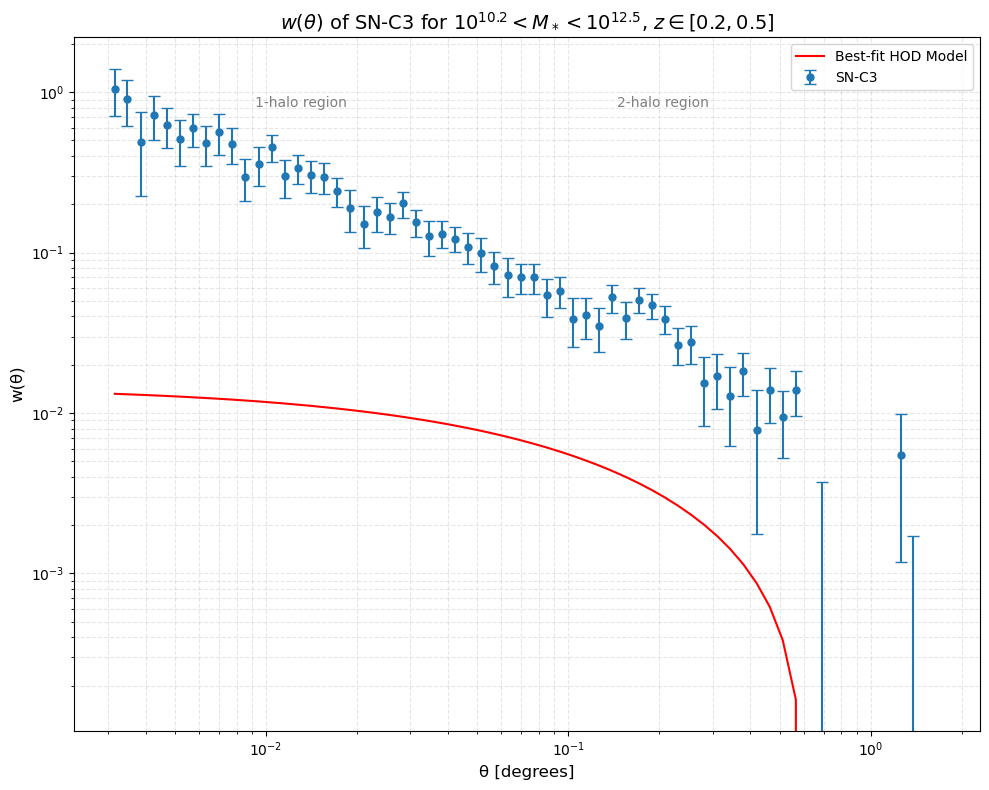

HOD fit results: M_min = 10^0.00, M_1 = 10^13.98, alpha = 1.24


In [29]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']

# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
#w_model = sub1.hod_model(logM_min, logM_1, alpha) 
w_model = sub1.hod_model(*hod_params)

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()

print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

In [30]:
# Compute stellar-to-halo mass ratio
logM_star = SM_min  # log stellar mass threshold
logM_halo = logM_min  # From HOD fit

M_star = 10**logM_star
M_halo = 10**logM_halo
SHMR = M_star / M_halo

print(f"  ➤ Estimated Stellar-to-Halo Mass Ratio (SHMR): {SHMR:.2e}")


15848885619.20342


In [31]:

hod_params, pcov = sub1.fit_hod(p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.95], [13.0, 14.0, 1.05]))

results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

AssertionError: the HOD model you've supplied masks out all given masses!

In [ ]:
z_min, z_max =   1.0, 1.1
SM_min, SM_max = 10.5, 12.5
    
sub2 = dv.Selection(t, randoms,z_min, z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
hod_params, pcov = sub2.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])

res2 = sub1.get_results()

logM_min, logM_1, alpha = res2['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

In [ ]:
z_min, z_max = 0.4, 0.5
SM_min, SM_max =  10.5, 12.5
    
sub3 = dv.Selection(t, randoms,z_min, z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
hod_params, pcov = sub3.fit_hod()  #  p0=[12.5, 13.5, 1.0], bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])

res3 = sub1.get_results()

logM_min, logM_1, alpha = res3['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")

In [ ]:
plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)


plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()

## Model prediction with best-fit parameters

In [ ]:
theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']
w_err = np.sqrt(var_w_obs)
xi_m_values = results['xi_m']

# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub1.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
#plt.plot(theta, xi_m_values, label=r'$\w_{dm}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')


plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-4,10.])

plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title(f'$w(\\theta)$ of SN-C3 for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

# Add annotations
plt.text(0.2, 0.9, "1-halo region", transform=plt.gca().transAxes, color='gray')
plt.text(0.6, 0.9, "2-halo region", transform=plt.gca().transAxes, color='gray')


plt.tight_layout()
plt.show()


In [ ]:
xi_m_values = results['xi_m']
xi_g_values = results['xi_g']


# Model prediction with best-fit parameters
logM_min, logM_1, alpha = results['hod_params']
w_model = sub1.hod_model(logM_min, logM_1, alpha) 

plt.figure(figsize=(10, 8))

plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='dodgerblue', label= 'SN-C3',capsize=4, markersize=5)
plt.plot(theta, w_model, label='Best-fit HOD Model', color='red')
plt.plot(theta, xi_m_values, label=r'(Matter-Matter) corr. function', linestyle='dashed', color='black')
plt.plot(theta, xi_g_values, label=r'(Galaxy-Galaxy) corr. function', linestyle='dashed', color='blueviolet')


plt.xscale('log')
plt.yscale('log')
#plt.ylim([1e-4, 10.])
plt.xlabel('θ [degrees]', fontsize=12)
plt.ylabel('w(θ)', fontsize=12)
plt.title('Correlation Function SN-C3')

plt.legend(fontsize=10, framealpha=0.8)
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.show()


## Now trying all my fields and different redshift bins using Selection class that finds the best fit for my 3 HOD parameters

In [ ]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

# Field details
fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
    },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
    }
}

config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'
}

# Fixed redshift range
z_min, z_max = 0.2, 0.5

# Define stellar mass bins
SM_bins = [(8.17, 8.6), (8.6, 9.0), (9.0, 9.6), (9.6, 10.5), (10.5, 12.5)]
colors = ["blue", "green", "red", "purple", "orange"]

# Initialize storage
all_results = {sm_range: {} for sm_range in SM_bins}

# Process each stellar mass bin
for SM_min, SM_max in SM_bins:
    print(f"\n\n🔹 Processing stellar mass bin {SM_min}–{SM_max}")
    
    # Initialize bias estimator with the first field
    first_field = list(fields.keys())[0]
    first_catalog = Table.read(os.path.join(thesis_path, fields[first_field]["catalog"]))
    first_masked = Table.read(os.path.join(thesis_path, fields[first_field]["masked"]))
    first_catalog = join(first_catalog, first_masked, keys='id')
    first_catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
    first_randoms = Table.read(os.path.join(thesis_path, fields[first_field]["randoms"]))
    
    first_subsample = dv.Selection(
        catalog=first_catalog,
        randoms=first_randoms,
        z_min=z_min,
        z_max=z_max,
        SM_min=SM_min,
        SM_max=SM_max,
        config=config
    )
    first_results = first_subsample.get_results()
    
    estimator = dv.FieldBiasEstimator(
        xi_m=np.array(first_results['xi_m']),
        mask=(np.array(first_results['theta']) >= 0.1) & (np.array(first_results['theta']) <= 0.4)
    )
    
    bias_eff_dict = {}

    for field, paths in fields.items():
        print(f"\n🔸 Processing field: {field}")
        
        catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
        masked = Table.read(os.path.join(thesis_path, paths["masked"]))
        catalog = join(catalog, masked, keys='id')
        catalog.rename_columns(['ra_1', 'dec_1'], ['ra', 'dec'])
        randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))
        
        subsample = dv.Selection(
            catalog=catalog,
            randoms=randoms,
            z_min=z_min,
            z_max=z_max,
            SM_min=SM_min,
            SM_max=SM_max,
            config=config
        )

        hod_params, pcov = subsample.fit_hod(
            p0=[12.5, 13.5, 1.0],
            bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])
        )

        results = subsample.get_results()
        
        bias_eff = subsample.gg.bias_effective_tracer
        bias_eff_dict[field] = bias_eff
        print(f"  ➤ bias_eff = {bias_eff:.3f}")

        logM_min, logM_1, alpha = results['hod_params']
        print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
              f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")
        
        estimator.add_field(
            field_name=field,
            xi_g=np.array(results['xi_g']),
            w_theta=np.array(results['w_theta']),
            w_theta_error=np.sqrt(np.array(results['var_w_theta_bootstrap'])),
            sum_rr=np.array(results['rr_counts'])
        )
    
    print("\nIndividual Field Results:")
    individual_results = estimator.fit_individual_fields()
    for name, b, be, ic in individual_results:
        print(f"{name}: b = {b:.3f} ± {be:.3f}, IC = {ic:.4f}")
    
    global_b, global_be = estimator.fit_combined()
    print(f"\nGlobal bias estimate: {global_b:.3f} ± {global_be:.3f}")
    
    all_results[(SM_min, SM_max)] = {
        'individual': individual_results,
        'global_b': global_b,
        'global_be': global_be,
        'estimator': estimator,
        'bias_eff': bias_eff_dict
    }


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        #theta = first_results['theta']
        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        #ax.scatter(theta, w_theta, label=field_data['name'])
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', label=field_data['name'], capsize=3)

    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue  # Skip non-COSMOS fields

        results = subsample.get_results()
        theta = results['theta']        
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', label='This work', capsize=3)
        #ax.scatter(theta, w_theta, label='This work')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ [COSMOS only] for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:

shuntov_theta = np.array([
    8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03, 1.9095e-02,
    4.1869e-02, 9.3389e-02, 2.0352e-01, 4.3985e-01, 8.6697e-01
])

shuntov_wtheta = np.array([
    4.0512, 2.1335, 0.76826, 0.60844, 0.23972,
    0.064465, 0.021901, 0.0086372, 0.002626, -0.0046342
])

shuntov_wtheta_err = np.array([
    1.4703, 0.5844, 0.19946, 0.11059, 0.10579,
    0.051982, 0.018514, 0.012101, 0.0047944, 0.0036775
])

#theta = np.exp(dd.meanlogr)




In [ ]:
for (SM_min, SM_max), result in all_results.items():
    if SM_min < 10.5:
        continue  # only plot for log(M*) > 10.5 bin

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', label='This work', capsize=3)

    # Overlay Shuntov+2022 data
    ax.errorbar(
        shuntov_theta, shuntov_wtheta, yerr=shuntov_wtheta_err,
        fmt='s--', color='black', capsize=3, label='Shuntov+2022 '
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
for (SM_min, SM_max), result in all_results.items():

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    for field_data in estimator.fields:

        results = subsample.get_results()
        theta = results['theta']
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.scatter(theta, w_theta, label=field_data['name'])

    # Overlay Shuntov+2022 data
    ax.scatter(
        shuntov_theta, shuntov_wtheta, label='Shuntov+2022 '
    )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()

In [ ]:
shuntov_data = {
    (10.5, 12.5): {
        "theta": np.array([
            8.6213e-04, 1.8266e-03, 3.8500e-03, 8.4446e-03,
            1.9095e-02, 4.1869e-02, 9.3389e-02, 2.0352e-01,
            4.3985e-01, 8.6697e-01
        ]),
        "wtheta": np.array([
            4.0512, 2.1335, 0.76826, 0.60844,
            0.23972, 0.064465, 0.021901, 0.0086372,
            0.0026260, -0.0046342
        ]),
        "error": np.array([
            1.4703, 0.58440, 0.19946, 0.11059,
            0.10579, 0.051982, 0.018514, 0.012101,
            0.0047944, 0.0036775
        ])
    },
    (9.6, 10.5): {
        "theta": np.array([
            8.6177e-04, 1.8088e-03, 3.9387e-03, 8.6512e-03,
            1.9151e-02, 4.2155e-02, 9.3135e-02, 2.0382e-01,
            4.4044e-01, 8.6983e-01
        ]),
        "wtheta": np.array([
            2.4589, 1.4099, 0.66725, 0.40769,
            0.18806, 0.072816, 0.011834, 0.0077454,
            0.0029769, -0.0041483
        ]),
        "error": np.array([
            0.35086, 0.11457, 0.070194, 0.052862,
            0.046929, 0.022189, 0.0089981, 0.0070251,
            0.0029207, 0.0022315
        ])
    },
    (9.0, 9.6): {
        "theta": np.array([
            8.3259e-04, 1.8063e-03, 3.9674e-03, 8.7145e-03,
            1.9194e-02, 4.2263e-02, 9.3085e-02, 2.0379e-01,
            4.4007e-01, 8.6861e-01
        ]),
        "wtheta": np.array([
            1.2910, 0.97706, 0.52575, 0.33105,
            0.15498, 0.061639, 0.012956, 0.0081038,
            0.0026256, -0.0043871
        ]),
        "error": np.array([
            0.16438, 0.080514, 0.037668, 0.037046,
            0.029617, 0.016203, 0.0084722, 0.0077168,
            0.0032781, 0.0026839
        ])
    },
    (8.6, 9.0): {
        "theta": np.array([
            8.4966e-04, 1.8031e-03, 3.9695e-03, 8.7495e-03,
            1.9216e-02, 4.2306e-02, 9.3108e-02, 2.0376e-01,
            4.4003e-01, 8.6822e-01
        ]),
        "wtheta": np.array([
            0.86374, 0.76856, 0.43005, 0.26244,
            0.13492, 0.050636, 0.012632, 0.0066597,
            0.0023886, -0.0037334
        ]),
        "error": np.array([
            0.098497, 0.043001, 0.033822, 0.023979,
            0.019220, 0.011188, 0.0070628, 0.0067357,
            0.0029484, 0.0024237
        ])
    },
    (8.17, 8.6): {
        "theta": np.array([
            8.4620e-04, 1.8016e-03, 3.9815e-03, 8.7588e-03,
            1.9257e-02, 4.2327e-02, 9.3100e-02, 2.0381e-01,
            4.4014e-01, 8.6768e-01
        ]),
        "wtheta": np.array([
            0.60852, 0.56341, 0.32357, 0.19411,
            0.10953, 0.040942, 0.012872, 0.0058622,
            0.0021337, -0.0033312
        ]),
        "error": np.array([
            0.057764, 0.029369, 0.022334, 0.019434,
            0.014293, 0.0085523, 0.0054175, 0.0060078,
            0.0021963, 0.0020317
        ])
    }
}


In [ ]:
for (SM_min, SM_max), result in all_results.items():
    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot my data
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o-', capsize=3,  label='COSMOS (this work)')

    # Plot Shuntov data 
    if (SM_min, SM_max) in shuntov_data:
        sd = shuntov_data[(SM_min, SM_max)]
        ax.errorbar(
            sd['theta'], sd['wtheta'], yerr=sd['error'],
            fmt='s--', color='black', capsize=3, label='Shuntov+2022'
        )

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.legend()
    #ax.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_SM_{SM_min}_{SM_max}.png")
    plt.show()

## Shuntov+2022, $z \in [0.2, 0.5]$

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))

for (mass_range, color) in zip(shuntov_data, colors):
    data = shuntov_data[mass_range]
    label = f"log(M*/M☉): {mass_range[0]}–{mass_range[1]}"
    ax.errorbar(data["theta"], data["wtheta"], yerr=data["error"],
                fmt='o', label=label, color=color, capsize=3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("θ [deg]")
ax.set_ylabel("w(θ)")
ax.set_title("Angular Correlation Function from Shuntov+2022, $z \in [0.2, 0.5]$'")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))

# Plot both datasets
fig, ax = plt.subplots(figsize=(10, 7))

for i, (mass_bin, data) in enumerate(shuntov_data.items()):
    color = colors[i]
    label = f"Shuntov+ ({mass_bin[0]} < log(M) < {mass_bin[1]})"
    ax.errorbar(data["theta"], data["wtheta"], yerr=data["error"], fmt='o', label=label, color=color)

    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']


        data = f"This work ({mass_bin[0]} < log(M) < {mass_bin[1]})"
        ax.errorbar(theta, w_theta, yerr=w_theta_err,  fmt='s--', label=data, color=color)



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Comparison of $w(\\theta)$ across stellar mass bins')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# Define a colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(shuntov_data)))

# Plot both datasets
fig, ax = plt.subplots(figsize=(10, 7))

for i, (mass_bin, data) in enumerate(shuntov_data.items()):


#for (SM_min, SM_max), result in all_results.items():
    color = colors[i]
    estimator = result['estimator']

    # Plot my data
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

       # theta = config['min_sep'] * (10 ** (np.arange(len(field_data['w_theta'])) * config['bin_size']))
        results = subsample.get_results()
        theta = results['theta']

        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']
        
        data = f"This work ({mass_bin[0]} < log(M) < {mass_bin[1]})"
        #ax.errorbar(theta, w_theta, yerr=w_theta_err,  fmt='s--', label=data, color=color)
        ax.scatter(theta, w_theta, label=data, color=color)



ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Comparison of $w(\\theta)$ across stellar mass bins')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
for (SM_min, SM_max), result in all_results.items():

    estimator = result['estimator']
    fig, ax = plt.subplots(figsize=(8, 6))

    # Retrieve Shuntov data
    shuntov = shuntov_data[(SM_min, SM_max)]
    shuntov_theta = shuntov["theta"]
    shuntov_wtheta = shuntov["wtheta"]
    shuntov_error = shuntov["error"]

    # Plot your COSMOS measurements
    for field_data in estimator.fields:
        if field_data['name'] != 'COSMOS':
            continue

        results = subsample.get_results()
        theta = results['theta']

        #theta = shuntov_theta  # Use same θ as Shuntov
        w_theta = field_data['w_theta']
        w_theta_err = field_data['w_error']

        ax.errorbar(theta, w_theta, yerr=w_theta_err, fmt='o', color='blue', label='This work', capsize=3)

        # HOD fitting for this stellar mass bin
        sub = dv.Selection(t, randoms, z_min=0.2, z_max=0.5, SM_min=SM_min, SM_max=SM_max, config=config)
        hod_params, pcov = sub.fit_hod(
            p0=[12.5, 13.5, 1.0],
            bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])
        )
        w_model = sub.hod_model(*hod_params)
        xi_m_values = sub.get_results()['xi_m']

        ax.plot(theta, w_model, label='Best-fit HOD Model', color='red')
        # ax.plot(theta, xi_m_values, label=r'$\omega_{dm}(\theta)$ (Matter)', linestyle='dashed', color='black')

    # Plot Shuntov+2022 data
    ax.errorbar(shuntov_theta, shuntov_wtheta, yerr=shuntov_error, fmt='s', color='black', label='Shuntov+2022', capsize=3)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\theta$ [degrees]', fontsize=12)
    ax.set_ylabel(r'$w(\theta)$', fontsize=12)
    ax.set_title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_*$, $z \in [0.2, 0.5]$', fontsize=14)
    ax.set_ylim([1e-4, 10])
    ax.legend(fontsize=10, framealpha=0.8)
    ax.grid(True, which="both", ls="--", alpha=0.3)

    ax.text(0.2, 0.9, "1-halo region", transform=ax.transAxes, color='gray')
    ax.text(0.6, 0.9, "2-halo region", transform=ax.transAxes, color='gray')

    plt.tight_layout()
    plt.savefig(f"wtheta_COSMOS_vs_Shuntov_HOD_SM_{SM_min}_{SM_max}.png")
    plt.show()


In [ ]:
shuntov_theta = shuntov_data[(SM_min, SM_max)]["theta"]
min_sep = 8e-4  # or whatever matches Shuntov's smallest theta
nbins = 10
bin_slop = 0.1
bin_size = np.log10(shuntov_theta[1]/shuntov_theta[0])  # Check this!

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': min_sep, #  0.003, 'max_sep': 1.78, 
    'nbins': nbins,
    'bin_size': bin_size, #  0.1
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



z_min, z_max = 0.2, 0.5
SM_min, SM_max =  10.5, 12.5
    
sub1 = dv.Selection(t, randoms,z_min, z_max,SM_min, SM_max, config)    # if i put the upper limit at 12.5 logSM then it is considered open-ended

# Fit HOD with custom bounds
hod_params, pcov = sub1.fit_hod(
    p0=[12.5, 13.5, 1.0],
    bounds=([12.0, 13.0, 0.5], [13.0, 14.0, 1.5])
)

results = sub1.get_results()

logM_min, logM_1, alpha = results['hod_params']
print(f"HOD fit results: M_min = 10^{logM_min:.2f}, "
      f"M_1 = 10^{logM_1:.2f}, alpha = {alpha:.2f}")


plt.figure(figsize=(10, 8))

theta = results['theta']
w_obs = results['w_theta']
var_w_obs= results['var_w_theta_bootstrap']

w_err = np.sqrt(var_w_obs)



plt.figure(figsize=(10, 8))
plt.errorbar(theta, w_obs, yerr= w_err, fmt='o', color='blue',label= 'SN-C3', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title(f'$w(\\theta)$ for $10^{{{SM_min}}} < M_* < 10^{{{SM_max}}}$, $z \in [0.2, 0.5]$', fontsize=14)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


## Plot bias against z

In [ ]:
plt.figure(figsize=(8, 6))

# Set up redshift bin centers
z_centers = [(zmin + zmax) / 2 for (zmin, zmax) in z_ranges]

# Collect field names
field_names = list(fields.keys())

# Initialize storage
field_biases = {field: [] for field in field_names}
field_errors = {field: [] for field in field_names}
global_biases = []
global_errors = []
eff_biases = []

# Fill in the data from all_results dictonnary
for z_bin in z_ranges:
    results = all_results[z_bin]['individual']
    global_b = all_results[z_bin]['global_b']
    global_be = all_results[z_bin]['global_be']
    
    result_dict = {name: (b, be) for name, b, be, _ in results}
    for field in field_names:
        b, be = result_dict.get(field, (None, None))
        field_biases[field].append(b)
        field_errors[field].append(be)

    global_biases.append(global_b)
    global_errors.append(global_be)
    biases_eff.append(bias_eff)

# Plot individual field biases
for i, field in enumerate(field_names):
    plt.errorbar(
        z_centers,
        field_biases[field],
        yerr=field_errors[field],
        label=field,
        color=colors[i],
        marker='o',
        capsize=3,
        linestyle='-'
    )

# Now plot effective bias per field
for i, field in enumerate(field_names):
    eff_biases = []
    for z_bin in z_ranges:
        bias_eff_dict = all_results[z_bin]['bias_eff']
        eff_bias = bias_eff_dict.get(field, None)
        eff_biases.append(eff_bias)

    plt.plot(
        z_centers,
        eff_biases,
        color=colors[i],
        linestyle=':',
        linewidth=2,
        marker='x',
        label=f"{field} (eff)"
    )


# Plot global bias
plt.errorbar(
    z_centers,
    global_biases,
    yerr=global_errors,
    label='Global Bias',
    color='black',
    marker='s',
    linestyle='--',
    capsize=4,
    linewidth=2
)




plt.xlabel("Redshift", fontsize=14)
plt.ylabel("Bias", fontsize=14)
plt.title("Effective Bias vs Redshift (High SM, 10 < log SM < 12.5)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(os.path.join(res,"Bias_eff_vs_z_for_High_SM.png"))

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

#1 degree sep in Mpc: 25.67767075127877

